# Setup

In [27]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()
%matplotlib inline

transactions = pd.read_csv("./financial_transactions/transactions_data.csv")
transactions.set_index("id")


,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
id,,,,,,,,,,,
7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8966547,2010-12-31 23:48:00,1941,1109,$2.39,Swipe Transaction,77275,Campbell,TX,75422.0,5812,NaN
8966548,2010-12-31 23:49:00,1145,5444,$20.39,Swipe Transaction,56060,Appleton,WI,54913.0,4121,NaN
8966549,2010-12-31 23:51:00,487,2835,$85.75,Swipe Transaction,36936,Albany,NY,12203.0,4900,NaN


# Présentation des données transactions
Nous intérprétons les données suivantes:
- client_id comme Client
- merchant_xxx comme Magasin

NB: La colonne 'mcc' représente des codes correspondant à la catégorie de l'achat. Ces codes sont repris dans le fichier `mcc_codes.json`.
Son utilisation ici ne sera pas très pertinente, nous ignorerons cette colonne

In [28]:
transactions.groupby('client_id').client_id.count() # 1137 clients uniques


client_id
0       1113
1        997
2       1025
3        527
4       1504
        ... 
1994      64
1995    1191
1996     849
1997    1080
1998     388
Name: client_id, Length: 1137, dtype: int64

In [29]:
# Classement de la plus grosse transaction par magasin et par état

transactions.groupby(["merchant_state", "merchant_id"]).apply(lambda df: df.loc[df.amount.idxmax()]).amount
# On groupe les états et les identifiants des magasins, et on trie le montant de chaque transaction (ASC)
# Et on y lie le montant correspondant.

C:\Users\Hugo\AppData\Local\Temp\ipykernel_56192\1003607640.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions.groupby(["merchant_state", "merchant_id"]).apply(lambda df: df.loc[df.amount.idxmax()]).amount


merchant_state  merchant_id
AK              2602           $128.44
                5248            $84.21
                7257           $751.42
                11468           $34.24
                12636           $25.32
                                ...   
WY              90461            $9.79
                90709           $93.48
                92883           $56.69
                94625           $32.15
                96049           $74.82
Name: amount, Length: 41378, dtype: object

In [30]:
# Le nombre de transactions, le montant minimum et maximum, par état
transactions.groupby(["merchant_state"]).amount.agg([len, min, max])

C:\Users\Hugo\AppData\Local\Temp\ipykernel_56192\3133034948.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  transactions.groupby(["merchant_state"]).amount.agg([len, min, max])
C:\Users\Hugo\AppData\Local\Temp\ipykernel_56192\3133034948.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  transactions.groupby(["merchant_state"]).amount.agg([len, min, max])


,len,min,max
merchant_state,,,
AK,793,$-102.00,$99.79
AL,16670,$-100.00,$999.00
AR,9554,$-100.00,$99.89
AZ,18554,$-100.00,$99.99
Andorra,32,$10.76,$47.64
...,...,...,...
Vietnam,11,$-219.00,$264.37
WA,29038,$-100.00,$998.37
WI,17067,$-100.00,$99.98


#### Nous allons d'abord retirer les transactions venant d'autres pays, elles ne nous intéressent pas dans ce projet.

In [31]:

drop_indexes = transactions[ (transactions["merchant_state"].str.len() > 2) ].index;

transactions = transactions.drop(drop_indexes)

# Traitement des valeurs nulles
Lorsqu'une transaction est faite en ligne, le code postal et l'état du magasin ne peuvent pas exister.
Nous allons donc remplacer ces cellules vides pour une meilleure visibilité et un futur traitement de ces données.

Aussi, certaines transactions peuvent être erronées. Celles qui ne le sont pas auront la mention "No error"


In [32]:
# Certaines valeurs sont nulles lorsque 'use_chip' est égal à 'Online Transaction'. C'est le cas de merchant_state et zip.
transactions[pd.isnull(transactions.merchant_state)]


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,$261.58,Online Transaction,50292,ONLINE,NaN,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,$26.04,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,$10.17,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,$16.86,Online Transaction,16798,ONLINE,NaN,NaN,4121,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1240846,8966515,2010-12-31 23:08:00,1852,28,$20.48,Online Transaction,18563,ONLINE,NaN,NaN,4121,NaN
1240857,8966527,2010-12-31 23:28:00,1788,2538,$193.39,Online Transaction,73186,ONLINE,NaN,NaN,4814,NaN
1240858,8966528,2010-12-31 23:29:00,584,51,$269.30,Online Transaction,74934,ONLINE,NaN,NaN,3596,NaN
1240860,8966530,2010-12-31 23:31:00,1875,5955,$10.57,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN


In [33]:
# Nous remplaçons ces cellules vides par une information plus pertinente
transactions.merchant_state = transactions.merchant_state.fillna("Online")
transactions.zip = transactions.zip.fillna("Unknown")

# Vérifions bien que les états ne sont plus nuls.
pd.Series([transactions.merchant_state.isnull().sum(), transactions.zip.isnull().sum()], ["merchant_state", "zip"])


merchant_state    0
zip               0
dtype: int64

In [34]:
# Message d'erreur par défaut
transactions.errors = transactions.errors.fillna("No error")

In [35]:
# Présentation des données nettoyées des valeurs nulles.
# On voit bien les modifications appliquées sur les colonnes merchant_state, zip, et errors
transactions.loc[transactions.use_chip == "Online Transaction"].head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,Online,Unknown,4784,No error
8,7475336,2010-01-01 00:21:00,335,5131,$261.58,Online Transaction,50292,ONLINE,Online,Unknown,7801,No error
18,7475346,2010-01-01 00:34:00,394,4717,$26.04,Online Transaction,39021,ONLINE,Online,Unknown,4784,No error
24,7475353,2010-01-01 00:43:00,301,3742,$10.17,Online Transaction,39021,ONLINE,Online,Unknown,4784,No error
26,7475356,2010-01-01 00:45:00,566,3439,$16.86,Online Transaction,16798,ONLINE,Online,Unknown,4121,No error


# Nettoyage des données
Maintenant que les données sont complètes, il faut les rendres plus simple à manipuler.

C'est notamment le cas de la colonne "amount", qui est actuellement une chaîne de caractères, car elle commence par le symbole monétaire.
Bien que cela reste lisible pour nous, cette colonne ne peut pas être manipulée pour des chiffres.

Par exemple, on peut voir ci-dessous que la plus grande valeur (**top**) est $80.00, malgré la présences de transactions dépassant les $1000.
Mais, si l'on compare caractère par caractère, $1 est plus petit que $8, donc c'est $80.00 qui sortira vainqueur de cette comparaison.

In [36]:
transactions.amount.describe()

count     1233660
unique      37016
top        $80.00
freq        12983
Name: amount, dtype: object

In [37]:
# On convertit la colonne en valeur numérique, en retirant le premier caractère de la colonne 'amount'
transactions.amount = pd.to_numeric(transactions.amount.str[1:])
transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No error
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No error
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No error
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,No error
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No error


### Actuellement, la colonne **date** est considérée comme un string par pandas.
On va la convertir en date pour pouvoir la manipuler efficacement.  
Nous allons également en profiter pour enregistrer le mois et le jour de la transaction.

In [38]:
transactions["parsed_date"] = pd.to_datetime(transactions.date, format="%Y-%m-%d %H:%M:%S")

transactions["month"] = transactions["parsed_date"].apply(lambda d: d.month)
transactions["day"] = transactions["parsed_date"].apply(lambda d: d.day)

transactions.tail()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,parsed_date,month,day
1240875,8966547,2010-12-31 23:48:00,1941,1109,2.39,Swipe Transaction,77275,Campbell,TX,75422.0,5812,No error,2010-12-31 23:48:00,12,31
1240876,8966548,2010-12-31 23:49:00,1145,5444,20.39,Swipe Transaction,56060,Appleton,WI,54913.0,4121,No error,2010-12-31 23:49:00,12,31
1240877,8966549,2010-12-31 23:51:00,487,2835,85.75,Swipe Transaction,36936,Albany,NY,12203.0,4900,No error,2010-12-31 23:51:00,12,31
1240878,8966550,2010-12-31 23:54:00,234,2052,60.00,Swipe Transaction,27092,Dallas,TX,75208.0,4829,No error,2010-12-31 23:54:00,12,31
1240879,8966551,2010-12-31 23:56:00,162,2240,140.96,Swipe Transaction,15574,Mcallen,TX,78503.0,3393,No error,2010-12-31 23:56:00,12,31


### Suppression des données
Nous supposons qu'un client ne peut faire 2 transactions au même moment avec la même carte, nous allons les retirer.



In [39]:
transactions_before_removal = transactions;

transactions = transactions.drop_duplicates(subset=['parsed_date', 'client_id', 'card_id'], keep="last")


# On peut observer une suppression de 7220 doublons
pd.Series([transactions_before_removal.shape[0], transactions.shape[0]])


0    1233660
1    1226440
dtype: int64

# Réponse à la problématique
Maintenant que les données sont nettoyées, nous pouvons tenter de répondre à la problématique.  
Pour rappel, nous souhaitons observer les tendances de dépenses des gens.  
Plus précisement, nous regarderons les tendances suivantes:
-   Dépenses par zones géographiques.
-   Le nombre de transactions selon le jour, le mois.

In [56]:
# Avant, observation de la moyenne de toutes les transactions
transactions.amount.mean()

np.float64(43.864634804800865)

<Axes: title={'center': 'Dépenses totales par état'}, ylabel='amount'>

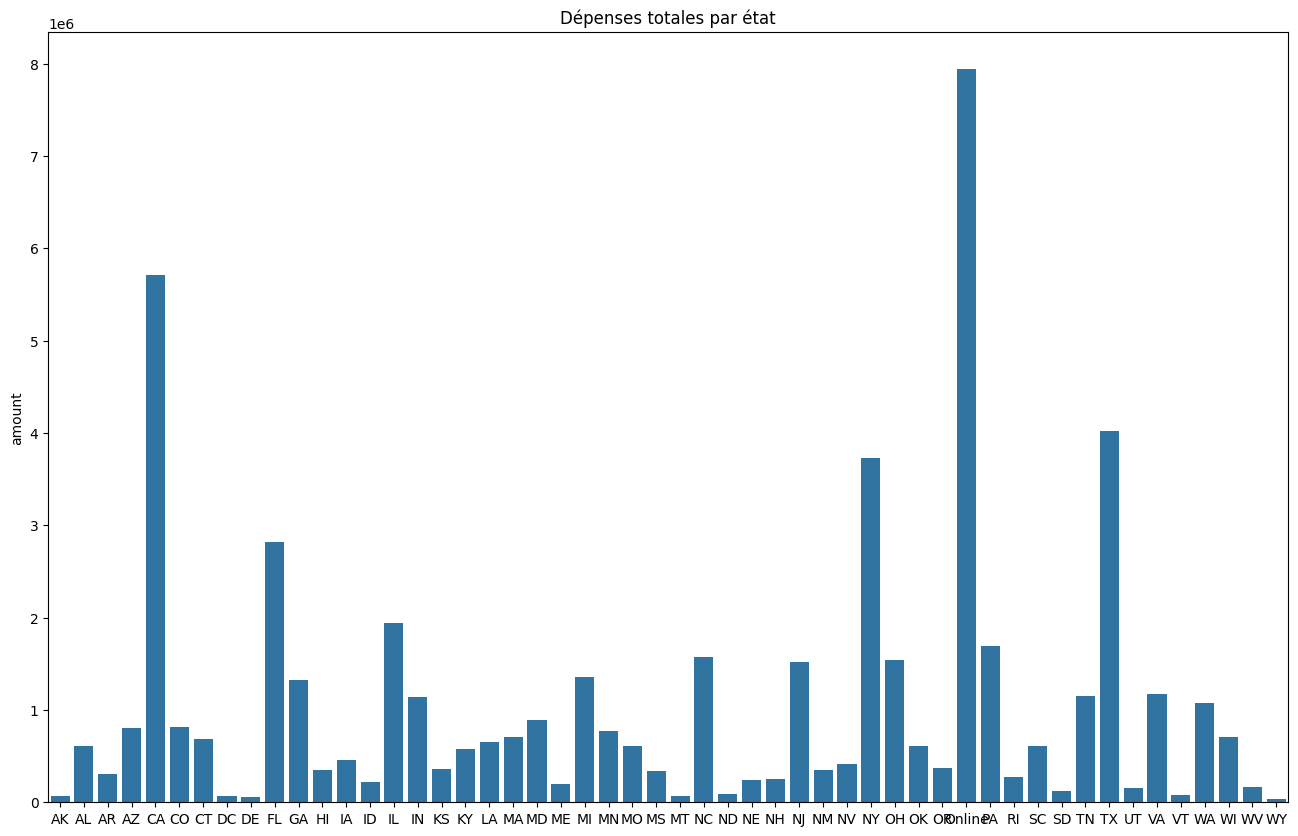

In [ ]:
# Dépenses par zones géographiques
plt.figure(figsize=(16,10))
plt.title("Dépenses totales par état")

# montant des dépenses par état
transactions_by_state = transactions.groupby(['merchant_state']).amount
amount_by_state = transactions_by_state.sum()
sns.barplot(x=list(transactions_by_state.indices), y=amount_by_state)


In [41]:
pd.Series([amount_by_state["CA"], amount_by_state["Online"]], ["Californie", "En ligne"])

Californie    5715336.47
En ligne      7942632.11
dtype: float64

Ce graphique nous permet de voir que l'état CA (**Californie**) est le plus dépensier, avec plus de 5.700.000 dollars de dépenses en tout.  
Il nous permet également de voir que les américains dépensent beaucoup plus sur internet que dans les magasins, avec plus de 7.900.000 dollars en tout.  
Ci-dessous, nous pouvons observer que la moyenne de dépense par état est de 1.034.564 dollars

In [42]:
round(float(amount_by_state.describe()["mean"]), 2)

1034564.28

### Tendances de dépenses selon la période

np.float64(43.864634804800865)

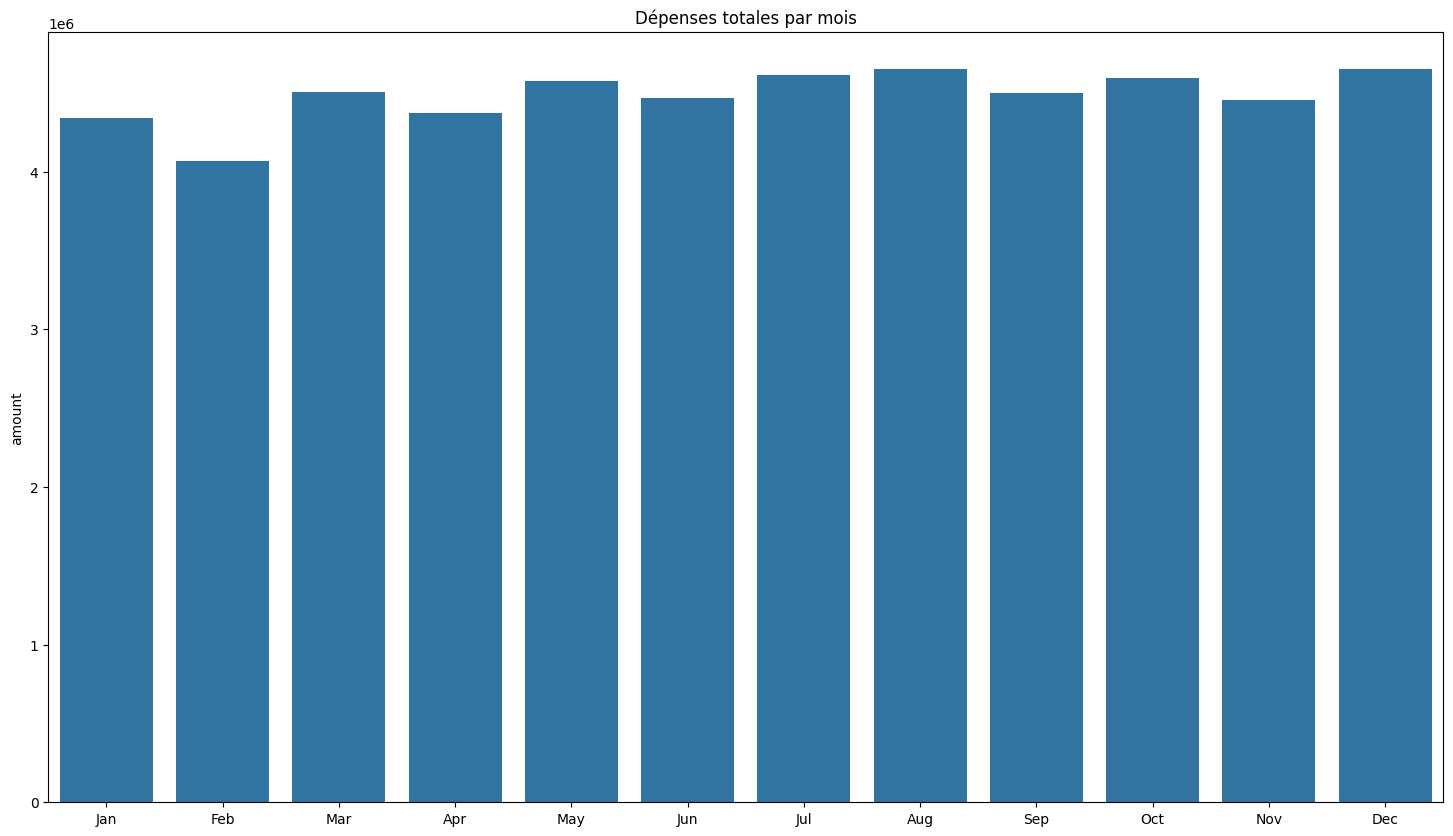

In [55]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(18,10))
plt.title("Dépenses totales par mois")

transactions_by_date = transactions.groupby(['month']).amount
amount_by_date = transactions_by_date.sum()
sns.barplot(x=months, y=amount_by_date)
amount_by_date.describe()



Étant donné que le nombre de transactions est très grand, ce graphique est très compact.  
Nous allons donc nous intéresser à un état en particulier, et observer son évolution en fonction des mois.

<Axes: title={'center': 'Dépenses par mois: CA'}, xlabel='month', ylabel='amount'>

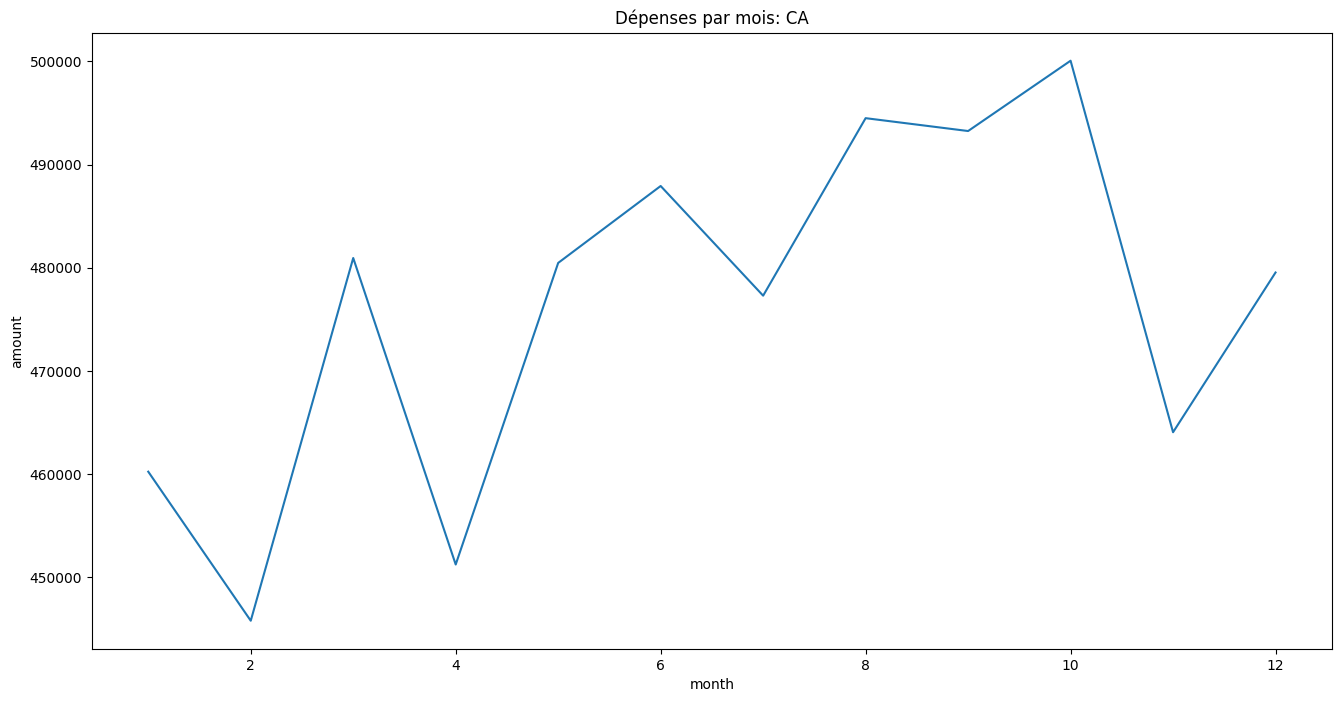

In [44]:

plt.figure(figsize=(16,8))

observed_state = "CA"
plt.title("Dépenses par mois: " + observed_state)

amount_by_state_per_month = transactions.groupby(['merchant_state', 'month']).amount.sum()

sns.lineplot(data=amount_by_state_per_month[observed_state])

Pour observer un autre état, il suffit de modifier la variable **observed_state**.  
Il est très clair que le mois le plus actif est le mois d'octobre.  
En extrapolant un peu, ce pic est potentiellement lié à Thanksgiving, ou bien Noël pour les plus prévoyants.  

##### Et si on observait cette même tendance en ligne ?

<Axes: title={'center': 'Dépenses par mois en ligne'}, xlabel='month', ylabel='amount'>

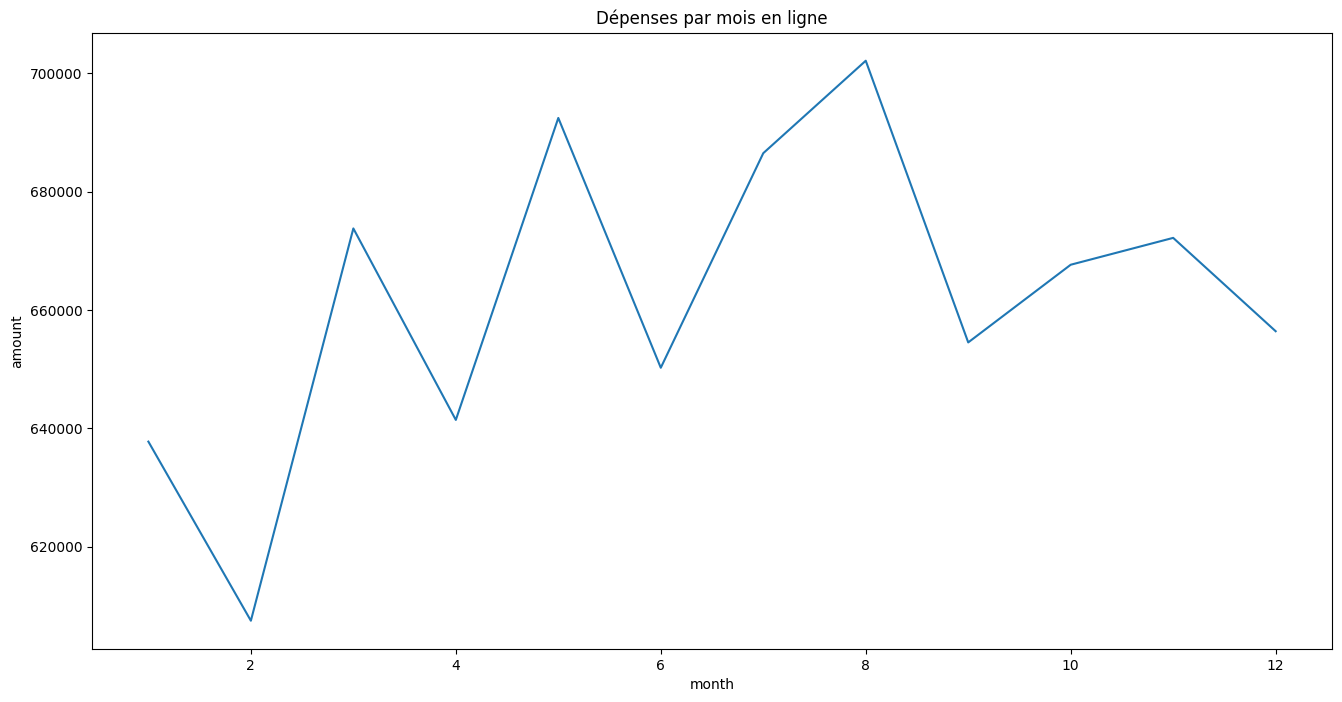

In [52]:
amount_by_state_per_month = transactions.groupby(['merchant_state', 'month']).amount.sum()

plt.figure(figsize=(16,8))
plt.title("Dépenses par mois en ligne")

sns.lineplot(data=amount_by_state_per_month["Online"])

On peut observer qu'en ligne, la tendance d'achat semble augmenter les mois impairs.  
Nous pensons que cette information n'est pas cohérente et n'est liée à aucun évènement en particulier.

#### Pour finir: La tendance journalière

<Axes: title={'center': 'Observation du mois: Dec'}, ylabel='amount'>

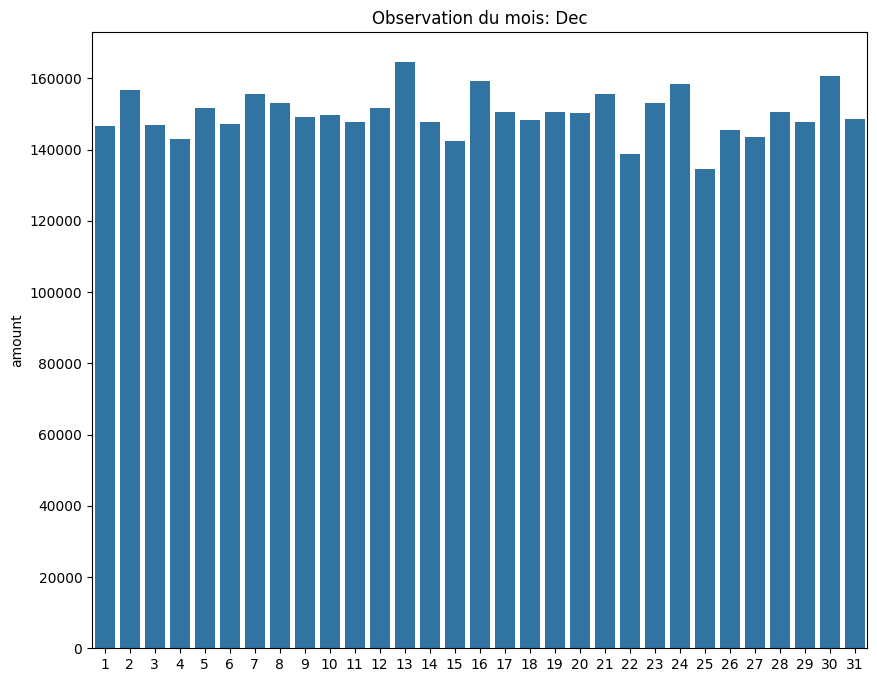

In [46]:
observed_month = 12

plt.figure(figsize=(10,8))
plt.title("Observation du mois: " + months[observed_month - 1])

amount_by_day_of_month = transactions.groupby(['month', 'day']).amount


sns.barplot(x=list(amount_by_day_of_month.sum()[observed_month].keys()), y=amount_by_day_of_month.sum()[observed_month])


Pour le mois de décembre par exemple, nous observons que le jour le moins "productif" est le 25 décembre:

In [47]:
pd.Series([amount_by_day_of_month.sum()[12][25], amount_by_day_of_month.sum()[12].min()], ["25 Décembre", "Jour le plus bas"])

25 Décembre         134561.61
Jour le plus bas    134561.61
dtype: float64

Probablement car il s'agit d'un jour férié; C'est également le cas du 1er janvier:

In [54]:
pd.Series([amount_by_day_of_month.sum()[1][1], amount_by_day_of_month.sum()[1].min()], ["1 Janvier", "Jour le plus bas"])


1 Janvier           124120.07
Jour le plus bas    124120.07
dtype: float64